<a href="https://colab.research.google.com/github/pjcroxas/ShortTermForecasting/blob/main/Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Lambda
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import SGD

from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dir = "drive/MyDrive/Research/Short-term Forecasting/data/Benchmark"

In [7]:
rsp_df = pd.read_excel(dir+"/rsp_weather.xlsx")
rsp_df.head()

,Station,Date,Time Range,Entry,Exit,Weekday_Weekend,Year,Month,Time Index,Day,Calendar Day,temperature_2m (°C),showers (mm),datetime
0,North Edsa,2024-01-01,05:00 - 05:59,0,0,False,2024,1,5,2,1,31.2,0.0,2024-01-01 05:00:00
1,North Edsa,2024-01-01,06:00 - 06:59,397,154,False,2024,1,6,2,1,31.5,0.0,2024-01-01 06:00:00
2,North Edsa,2024-01-01,07:00 - 07:59,558,488,False,2024,1,7,2,1,31.6,0.0,2024-01-01 07:00:00
3,North Edsa,2024-01-01,08:00 - 08:59,630,537,False,2024,1,8,2,1,30.7,0.0,2024-01-01 08:00:00
4,North Edsa,2024-01-01,09:00 - 09:59,841,633,False,2024,1,9,2,1,29.8,0.0,2024-01-01 09:00:00


### I. Model using Timeseries only

In [28]:
rsp_only = rsp_df[['Year', 'Month', 'Time Index', 'Day', 'Calendar Day',"Entry", "Exit"]]
rsp_cols = list(rsp_only.columns)

In [38]:
def create_sliding_window(df, feature_cols, target_col, window_size):
    """
    Create sliding window sequences for time series models (e.g., LSTM).

    Parameters
    ----------
    df : pandas.DataFrame
        Time-ordered dataframe (do NOT shuffle).
    feature_cols : list
        Columns used as input features.
    target_col : str
        Column to predict.
    window_size : int
        Number of past timesteps in each window.

    Returns
    -------
    X : np.ndarray
        Shape: (samples, timesteps, features)
    y : np.ndarray
        Shape: (samples,)
    """
    X, y = [], []

    for i in range(window_size, len(df)):
        X.append(df[feature_cols].iloc[i - window_size:i].values)
        y.append(df[target_col].iloc[i])
        # print(X, y)

    return np.array(X), np.array(y)

In [39]:
X, y = create_sliding_window(rsp_only, rsp_cols, "Entry", 5)

Streaming output truncated to the last 5000 lines.
       [2024,    1,   16,    3,   16, 1843, 3100],
       [2024,    1,   17,    3,   16, 2097, 4443],
       [2024,    1,   18,    3,   16, 2193, 5603],
       [2024,    1,   19,    3,   16, 2566, 4822]]), array([[2024,    1,   16,    3,   16, 1843, 3100],
       [2024,    1,   17,    3,   16, 2097, 4443],
       [2024,    1,   18,    3,   16, 2193, 5603],
       [2024,    1,   19,    3,   16, 2566, 4822],
       [2024,    1,   20,    3,   16, 2701, 3021]]), array([[2024,    1,   17,    3,   16, 2097, 4443],
       [2024,    1,   18,    3,   16, 2193, 5603],
       [2024,    1,   19,    3,   16, 2566, 4822],
       [2024,    1,   20,    3,   16, 2701, 3021],
       [2024,    1,   21,    3,   16,  987, 1879]]), array([[2024,    1,   18,    3,   16, 2193, 5603],
       [2024,    1,   19,    3,   16, 2566, 4822],
       [2024,    1,   20,    3,   16, 2701, 3021],
       [2024,    1,   21,    3,   16,  987, 1879],
       [2024,    1,    5,

In [45]:
X[1]

array([[2024,    1,    7,    2,    1,  558,  488],
       [2024,    1,    8,    2,    1,  630,  537],
       [2024,    1,    9,    2,    1,  841,  633],
       [2024,    1,   10,    2,    1, 1110,  788],
       [2024,    1,   11,    2,    1, 1412, 1145]])

In [46]:
y[1]

np.int64(1474)

In [47]:
def split_array(X, y, pct):
  # give the train set the first 70%
  train_size = int(len(rsp_only) * pct)
  X_train = X[:train_size]
  y_train = y[:train_size]

  X_test = X[train_size:]
  y_test = y[train_size:]

  return X_train, y_train, X_test, y_test

In [48]:
X_train, y_train, X_test, y_test = split_array(X, y, 0.7)

In [78]:
def create_model(input_shape):
    model = Sequential([
        LSTM(100, activation='relu', input_shape=input_shape),
        Dense(30, activation="relu"),
        Dense(10, activation="relu"),
        Dense(1),
        Lambda(lambda x: x * 400)
    ])

    model.compile(loss='mae',
                  optimizer="adam")
    return model

In [90]:
model = create_model((X_train.shape[1], X_train.shape[2]))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 100)            │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 30)             │         3,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_8 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,551 (181.84 KB)

 Trainable params: 46,551 (181.84 KB)

 Non-trainable params: 0 (0.00 B)

In [91]:
history = model.fit(X_train,
                    y_train,
                    epochs=200,
                    batch_size=70,
                    validation_data=(X_test, y_test),
                    verbose=2,
                    shuffle=False)

Epoch 1/200
16/16 - 2s - 111ms/step - loss: 35713.7422 - val_loss: 8939.6807
Epoch 2/200
16/16 - 0s - 10ms/step - loss: 6569.6362 - val_loss: 4561.5317
Epoch 3/200
16/16 - 0s - 10ms/step - loss: 3189.4944 - val_loss: 2473.5596
Epoch 4/200
16/16 - 0s - 14ms/step - loss: 1886.3518 - val_loss: 1738.4583
Epoch 5/200
16/16 - 0s - 14ms/step - loss: 1319.4858 - val_loss: 1365.7489
Epoch 6/200
16/16 - 0s - 23ms/step - loss: 973.6719 - val_loss: 1008.7344
Epoch 7/200
16/16 - 0s - 15ms/step - loss: 759.0311 - val_loss: 891.7178
Epoch 8/200
16/16 - 0s - 18ms/step - loss: 737.2158 - val_loss: 784.3491
Epoch 9/200
16/16 - 0s - 15ms/step - loss: 644.1504 - val_loss: 718.1944
Epoch 10/200
16/16 - 0s - 17ms/step - loss: 601.4711 - val_loss: 712.4719
Epoch 11/200
16/16 - 0s - 10ms/step - loss: 577.7809 - val_loss: 698.9987
Epoch 12/200
16/16 - 0s - 10ms/step - loss: 556.3943 - val_loss: 656.2567
Epoch 13/200
16/16 - 0s - 10ms/step - loss: 516.3274 - val_loss: 625.0549
Epoch 14/200
16/16 - 0s - 9ms/step

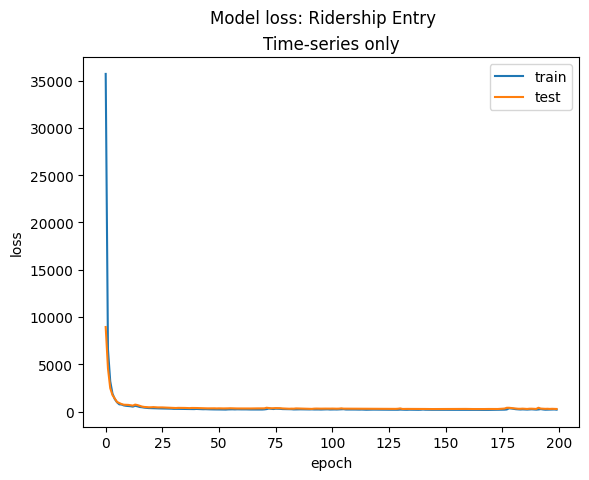

In [92]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.suptitle('Model loss: Ridership Entry')
plt.title("Time-series only")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [93]:
# Predict
forecast = model.predict(X_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [94]:
# measure MAE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, forecast)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 268.2494812011719


### II. Model using weather data

In [95]:
rsp_df.columns

Index(['Station', 'Date', 'Time Range', 'Entry', 'Exit', 'Weekday_Weekend',
       'Year', 'Month', 'Time Index', 'Day', 'Calendar Day',
       'temperature_2m (°C)', 'showers (mm)', 'datetime'],
      dtype='object')

In [97]:
rsp_weather = rsp_df[['Year', 'Month', 'Time Index', 'Day', 'Calendar Day',"Entry", "Exit", "temperature_2m (°C)", "showers (mm)"]]
rsp_weather_cols = list(rsp_weather.columns)

In [99]:
X_w, y_w = create_sliding_window(rsp_weather, rsp_weather_cols, "Entry", 5)

Streaming output truncated to the last 5000 lines.
        1.864e+03, 2.760e+01, 0.000e+00],
       [2.024e+03, 2.000e+00, 1.400e+01, 7.000e+00, 2.400e+01, 1.527e+03,
        1.920e+03, 2.720e+01, 0.000e+00],
       [2.024e+03, 2.000e+00, 1.500e+01, 7.000e+00, 2.400e+01, 1.640e+03,
        2.301e+03, 2.700e+01, 0.000e+00]]), array([[2.024e+03, 2.000e+00, 1.200e+01, 7.000e+00, 2.400e+01, 2.034e+03,
        2.042e+03, 2.850e+01, 0.000e+00],
       [2.024e+03, 2.000e+00, 1.300e+01, 7.000e+00, 2.400e+01, 1.812e+03,
        1.864e+03, 2.760e+01, 0.000e+00],
       [2.024e+03, 2.000e+00, 1.400e+01, 7.000e+00, 2.400e+01, 1.527e+03,
        1.920e+03, 2.720e+01, 0.000e+00],
       [2.024e+03, 2.000e+00, 1.500e+01, 7.000e+00, 2.400e+01, 1.640e+03,
        2.301e+03, 2.700e+01, 0.000e+00],
       [2.024e+03, 2.000e+00, 1.600e+01, 7.000e+00, 2.400e+01, 2.239e+03,
        2.615e+03, 2.690e+01, 0.000e+00]]), array([[2.024e+03, 2.000e+00, 1.300e+01, 7.000e+00, 2.400e+01, 1.812e+03,
        1.864e+03

In [118]:
rsp_weather

,Year,Month,Time Index,Day,Calendar Day,Entry,Exit,temperature_2m (°C),showers (mm)
1,2024,1,6,2,1,397,154,31.5,0.0
2,2024,1,7,2,1,558,488,31.6,0.0
3,2024,1,8,2,1,630,537,30.7,0.0
4,2024,1,9,2,1,841,633,29.8,0.0
5,2024,1,10,2,1,1110,788,29.0,0.0
...,...,...,...,...,...,...,...,...,...
1691,2024,3,17,4,27,2168,4590,26.7,0.0
1692,2024,3,18,4,27,2504,4897,26.3,0.0
1693,2024,3,19,4,27,2430,3639,26.3,0.0
1694,2024,3,20,4,27,2255,2297,26.3,0.0


In [105]:
model_w = create_model((X_train.shape[1], X_train.shape[2]))
model_w.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 100)            │        44,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 30)             │         3,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_10 (Lambda)              │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,351 (184.96 KB)

 Trainable params: 47,351 (184.96 KB)

 Non-trainable params: 0 (0.00 B)

In [106]:
X_train, y_train, X_test, y_test = split_array(X_w, y_w, 0.7)

In [107]:
history = model_w.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=70,
                    validation_data=(X_test, y_test),
                    verbose=2,
                    shuffle=False)

Epoch 1/100
16/16 - 2s - 110ms/step - loss: 86671.0625 - val_loss: 27083.6133
Epoch 2/100
16/16 - 0s - 10ms/step - loss: 19827.8242 - val_loss: 14099.4404
Epoch 3/100
16/16 - 0s - 10ms/step - loss: 9527.8223 - val_loss: 7375.8892
Epoch 4/100
16/16 - 0s - 9ms/step - loss: 6093.7534 - val_loss: 5383.4829
Epoch 5/100
16/16 - 0s - 10ms/step - loss: 4533.5044 - val_loss: 4262.2969
Epoch 6/100
16/16 - 0s - 11ms/step - loss: 4304.3677 - val_loss: 3727.5452
Epoch 7/100
16/16 - 0s - 10ms/step - loss: 3093.8452 - val_loss: 3100.4790
Epoch 8/100
16/16 - 0s - 12ms/step - loss: 2813.3867 - val_loss: 2722.5369
Epoch 9/100
16/16 - 0s - 11ms/step - loss: 2464.5486 - val_loss: 2719.8945
Epoch 10/100
16/16 - 0s - 11ms/step - loss: 2414.7095 - val_loss: 2439.8267
Epoch 11/100
16/16 - 0s - 11ms/step - loss: 2142.2400 - val_loss: 2144.2913
Epoch 12/100
16/16 - 0s - 18ms/step - loss: 1848.6564 - val_loss: 2087.3521
Epoch 13/100
16/16 - 0s - 16ms/step - loss: 1808.7617 - val_loss: 2119.2549
Epoch 14/100
16/1

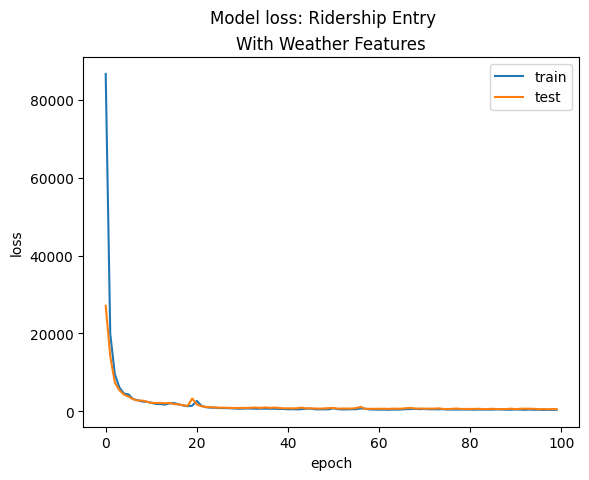

In [109]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.suptitle('Model loss: Ridership Entry')
plt.title("With Weather Features")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [111]:
# measure MAE
# Predict
forecast = model_w.predict(X_test)
mae = mean_absolute_error(y_test, forecast)
print(f"Mean Absolute Error: {mae}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Mean Absolute Error: 501.1391296386719


In [113]:
X_w[0]

array([[2.024e+03, 1.000e+00, 6.000e+00, 2.000e+00, 1.000e+00, 3.970e+02,
        1.540e+02, 3.150e+01, 0.000e+00],
       [2.024e+03, 1.000e+00, 7.000e+00, 2.000e+00, 1.000e+00, 5.580e+02,
        4.880e+02, 3.160e+01, 0.000e+00],
       [2.024e+03, 1.000e+00, 8.000e+00, 2.000e+00, 1.000e+00, 6.300e+02,
        5.370e+02, 3.070e+01, 0.000e+00],
       [2.024e+03, 1.000e+00, 9.000e+00, 2.000e+00, 1.000e+00, 8.410e+02,
        6.330e+02, 2.980e+01, 0.000e+00],
       [2.024e+03, 1.000e+00, 1.000e+01, 2.000e+00, 1.000e+00, 1.110e+03,
        7.880e+02, 2.900e+01, 0.000e+00]])